In [1]:
!pip install torchinfo early-stopping-pytorch

In [2]:
import torch, time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.datasets import load_diabetes
from torchinfo import summary
from early_stopping_pytorch import EarlyStopping

In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [4]:
data = load_diabetes()
data.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [5]:
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [6]:
X, y = load_diabetes(return_X_y=True,scaled=True)

In [7]:
X.shape, y.shape

((442, 10), (442,))

In [8]:
X, y

(array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990749, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06833155, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286131, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04688253,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452873, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00422151,  0.00306441]]),
 array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
   

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train = torch.from_numpy(X_train.astype(np.float32)).to(device)
X_test = torch.from_numpy(X_test.astype(np.float32)).to(device)
y_train = torch.from_numpy(y_train.astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

In [11]:
class CustomDataset(Dataset):

  def __init__(self,features,labels):
    super().__init__()
    self.features = features
    self.labels = labels

  def __len__(self):
    return self.features.shape[0]

  def __getitem__(self,idx):
    return self.features[idx], self.labels[idx]

In [12]:
torch.manual_seed(42)
train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test,y_test)

In [13]:
len(train_dataset), len(test_dataset)

(353, 89)

In [14]:
train_data_loader = DataLoader(dataset=train_dataset,batch_size=16,shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset,batch_size=16,shuffle=True)

In [15]:
for x, y in train_data_loader:
  print(x.shape, y.shape)
  break

torch.Size([16, 10]) torch.Size([16])


In [16]:
x, y

(tensor([[-0.0273,  0.0507, -0.0073, -0.0401, -0.0112, -0.0138,  0.0597, -0.0395,
          -0.0824, -0.0259],
         [ 0.0381,  0.0507, -0.0299, -0.0401, -0.0332, -0.0242, -0.0103, -0.0026,
          -0.0129,  0.0031],
         [-0.0164,  0.0507,  0.0024,  0.0150,  0.0218, -0.0101, -0.0250,  0.0343,
           0.0855,  0.0818],
         [ 0.0671, -0.0446,  0.0369, -0.0504, -0.0236, -0.0345,  0.0486, -0.0395,
          -0.0260, -0.0384],
         [ 0.0417, -0.0446, -0.0644,  0.0356,  0.0122, -0.0580,  0.1812, -0.0764,
          -0.0006, -0.0508],
         [ 0.0090, -0.0446, -0.0321, -0.0263,  0.0425, -0.0104,  0.1591, -0.0764,
          -0.0119, -0.0384],
         [ 0.0599,  0.0507,  0.0412,  0.0115,  0.0411,  0.0707, -0.0360,  0.0343,
          -0.0109, -0.0301],
         [-0.0418, -0.0446, -0.0666, -0.0470, -0.0373, -0.0433,  0.0486, -0.0395,
          -0.0562, -0.0135],
         [ 0.0199,  0.0507,  0.0455,  0.0299, -0.0621, -0.0558, -0.0729,  0.0269,
           0.0456,  0.0403],
 

In [17]:
class ANN(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(10,64)
    self.fc2 = nn.Linear(64,32)
    self.fc3 = nn.Linear(32,1)

  def forward(self,x):
    output = F.relu(self.fc1(x))
    output = F.relu(self.fc2(output))
    return self.fc3(output)

In [18]:
torch.manual_seed(42)
model = ANN().to(device)
model

ANN(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [19]:
summary(model)

Layer (type:depth-idx)                   Param #
ANN                                      --
├─Linear: 1-1                            704
├─Linear: 1-2                            2,080
├─Linear: 1-3                            33
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0

In [20]:
total_params = 0

for param in model.parameters():
  print(param.numel())
  total_params += param.numel()

print("Total parameters: ",total_params)

640
64
2048
32
32
1
Total parameters:  2817


In [21]:
criterion = nn.HuberLoss(delta=0.8)
optimizer = optim.AdamW(params=model.parameters(),lr=0.01,weight_decay=0.01)
early_stopping = EarlyStopping(patience=20,verbose=True)

In [22]:
epochs = 100
train_losses = []
test_losses = []

start_time = time.time()

for epoch in range(1,epochs+1):
  train_epoch_loss = 0
  test_epoch_loss = 0

  model.train()

  for batch_no, (X_train, y_train) in enumerate(train_data_loader):
      X_train, y_train = X_train.to(device), y_train.to(device)
      optimizer.zero_grad()
      y_pred = model(X_train)
      loss = criterion(y_pred,y_train)
      loss.backward()
      optimizer.step()
      train_epoch_loss += loss.item()

  train_losses.append(train_epoch_loss/len(train_data_loader))

  model.eval()

  with torch.no_grad():
    for batch_no, (X_test, y_test) in enumerate(test_data_loader):
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_pred = model(X_test)
      loss = criterion(y_pred,y_test)
      test_epoch_loss += loss.item()

  test_losses.append(test_epoch_loss/len(test_data_loader))

  print(f"Epoch: {epoch} -> Train Loss: {train_epoch_loss/len(train_data_loader)}, Test Loss: {test_epoch_loss/len(test_data_loader)}")

  early_stopping(test_epoch_loss/len(test_data_loader),model)

  if early_stopping.early_stop:
    print("Early stopping")
    break

print(f"Total training time: {(time.time() - start_time)/60} minutes.")

Epoch: 1 -> Train Loss: 122.66440482761548, Test Loss: 109.18539810180664
Validation loss decreased (inf --> 109.185398).  Saving model ...
Epoch: 2 -> Train Loss: 103.05151599386464, Test Loss: 74.209898630778
Validation loss decreased (109.185398 --> 74.209899).  Saving model ...
Epoch: 3 -> Train Loss: 57.885015653527304, Test Loss: 52.255004247029625
Validation loss decreased (74.209899 --> 52.255004).  Saving model ...
Epoch: 4 -> Train Loss: 51.837730407714844, Test Loss: 48.65909957885742
Validation loss decreased (52.255004 --> 48.659100).  Saving model ...
Epoch: 5 -> Train Loss: 50.829197386036746, Test Loss: 49.859327952067055
EarlyStopping counter: 1 out of 20
Epoch: 6 -> Train Loss: 52.88056680430537, Test Loss: 50.25654665629069
EarlyStopping counter: 2 out of 20
Epoch: 7 -> Train Loss: 53.08180153888205, Test Loss: 49.97127723693848
EarlyStopping counter: 3 out of 20
Epoch: 8 -> Train Loss: 52.038032863451086, Test Loss: 50.10307757059733
EarlyStopping counter: 4 out of 

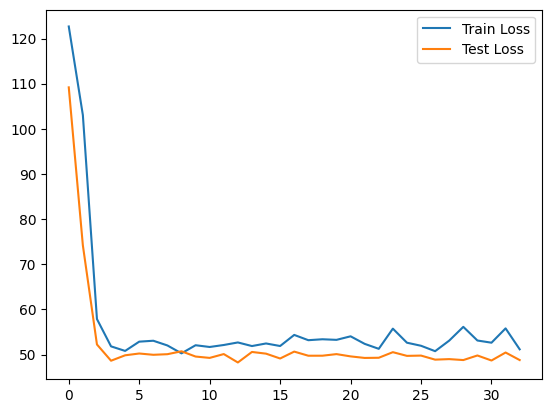

In [23]:
plt.plot(train_losses,label='Train Loss')
plt.plot(test_losses,label='Test Loss')
plt.legend()
plt.show()

In [24]:
torch.save(model,'diabetes_model.pt')